In [2]:
!python3 -m venv venv 
!. venv/bin/activate 

In [3]:
# Install required packages (modify as needed)
!pip install numpy pandas matplotlib flask django 
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu121


In [4]:
!pip uninstall -y numpy  # Uninstall any existing numpy version
!pip install "numpy<2" opencv-python
!pip install matplotlib seaborn scikit-learn

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
poke-env 0.9.0 requires numpy>=2.0.2, but you have numpy 1.26.4 which is incompatible.


In [5]:
# Example: Create a .vscode/settings.json file for Python linting and formatting
import os
os.makedirs('.vscode', exist_ok=True)
with open('.vscode/settings.json', 'w') as f:
    f.write('''{
    "python.linting.enabled": true,
    "python.linting.pylintEnabled": true,
    "python.formatting.provider": "black"
}''')
print("VS Code settings configured.")

VS Code settings configured.


In [6]:
import glob
import os
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
import numpy as np
import cv2

# TODO: Should this only include labeled images?
class YOLOv8SegmentationDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None):
        self.images = sorted(glob.glob(os.path.join(images_dir, '*', '*.png'))) 
        self.labels_dir = labels_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label_base = os.path.splitext(os.path.basename(img_path))[0] + '.txt'
        label_path = os.path.join(self.labels_dir, os.path.dirname(img_path).split(os.sep)[-1], label_base)
        img = read_image(img_path).float() / 255.0
        print(f"Image shape: {img.shape}, Label path: {label_path}")

        h, w = img.shape[1:]
        h_img, w_img = img.shape[1], img.shape[2]
        boxes = []
        masks = []
        labels = []

        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x1 = float(parts[1]) * w  
                    x2 = float(parts[3]) * w 
                    y1 = float(parts[2]) * h 
                    y2 = float(parts[-1]) * h 
                    boxes.append([x1, y1, x2, y2])
                    mask = np.zeros((h_img, w_img), dtype=np.uint8)
                    mask[int(y1):int(y2), int(x1):int(x2)] = 1  # Create a binary mask
                    masks.append(mask)
                    labels.append(class_id)
        else:
            print(f"Label file not found: {label_path}")

        boxes = torch.tensor(boxes, dtype=torch.float32)
        masks = torch.tensor(np.stack(masks), dtype=torch.uint8) if masks else torch.zeros((0, h, w), dtype=torch.uint8)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([idx])
        }

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target


import xml.etree.ElementTree as ET

# Cheat function to convert label to class ID. TODO:  Use the CVAT XML file to get the class ID.
def label_to_class_id(label):
    if label == 'Background':
        return 0
    elif label == 'Player 1':
        return 1
    elif label == 'Player 2':
        return 2
    return -1 # Invalid class ID

# Dataset loader for CVAT 1.1 annotation xml rather than YOLOv8 format
class CVATSegmentationDataset(Dataset):
    def __init__(self, images_dir, labels_file, transforms=None, x_offset=0, y_offset=0):
        super().__init__()
        self.images = sorted(glob.glob(os.path.join(images_dir, '*', '*.png')))
        self.labels_file = labels_file
        self.transforms = transforms
        self.x_offset = x_offset
        self.y_offset = y_offset

    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = self.images[index]
        img = read_image(img_path).float() / 255.0
        print(f"Image shape: {img.shape}, Image path: {img_path}")

        h, w = img.shape[1:]
        boxes = []
        labels = []
        mask = np.zeros((h, w), dtype=np.uint8)

        # Load annotations from CVAT XML file
        if os.path.exists(self.labels_file):
            tree = ET.parse(self.labels_file)
            root = tree.getroot()
            for track in root.findall('track'):
                label = label_to_class_id(track.get('label'))
                for box in track.findall('box'):
                    if box.get('frame') != str(index + 1):
                        continue
                    if box.get('occluded') == '1':
                        continue
                    if box.get('outside') == '1':
                        continue
                    x1 = float(box.get('xtl')) - self.x_offset
                    y1 = float(box.get('ytl')) - self.y_offset
                    x2 = float(box.get('xbr')) - self.x_offset
                    y2 = float(box.get('ybr')) - self.y_offset
                    boxes.append([x1, y1, x2, y2])
                    labels.append(label)
                    mask[int(y1):int(y2), int(x1):int(x2)] = label
                    break
                for polygon in track.findall('polygon'):
                    if polygon.get('frame') != str(index + 1 ):
                        continue
                    if polygon.get('occluded') == '1':
                        continue
                    if polygon.get('outside') == '1':
                        continue
                    points = polygon.get('points').split(';')
                    points = [list(map(float, point.split(','))) for point in points]
                    x_coords, y_coords = zip(*points)
                    x_coords = [x - self.x_offset for x in x_coords]
                    y_coords = [y - self.y_offset for y in y_coords]
                    # Recreate points with new xcoords and y_coords
                    points = np.array([x_coords, y_coords]).T
                    x1, y1 = min(x_coords), min(y_coords)
                    x2, y2 = max(x_coords), max(y_coords)
                    boxes.append([x1, y1, x2, y2])
                    labels.append(label)
                    # Fill poly with new label
                    cv2.fillPoly(mask, np.array([points], dtype=np.int32), label)
                    break
        target = {}
        target["boxes"] = torch.tensor(boxes, dtype=torch.float32)
        target["masks"] = torch.tensor(mask, dtype=torch.uint8).unsqueeze(0)  # Add channel dimension
        target["labels"] = torch.tensor(labels, dtype=torch.int64)
        return img, target
        

In [7]:
# data = YOLOv8SegmentationDataset(
#     images_dir='/home/tmelanson/stadium_dataset/images',
#     labels_dir='/home/tmelanson/stadium_dataset/labels',
#     transforms=None  # Add any transforms if needed
# )

data = CVATSegmentationDataset(
    images_dir='/home/tmelanson/stadium_dataset/images',
    labels_file='/home/tmelanson/stadium_dataset/annotations/battle3.xml',
    transforms=None,  # Add any transforms if needed
    x_offset=597,
    y_offset=295
)

/home/tmelanson/.local/lib/python3.10/site-packages/numpy/__init__.py
1.26.4
Image shape: torch.Size([3, 480, 720]), Image path: /home/tmelanson/stadium_dataset/images/battle3/frame_026430.png
Image 26429: torch.Size([3, 480, 720]), Boxes: torch.Size([0]), Labels: tensor([], dtype=torch.int64), Masks: torch.Size([1, 480, 720])
Image shape before resize: (480, 720, 3)


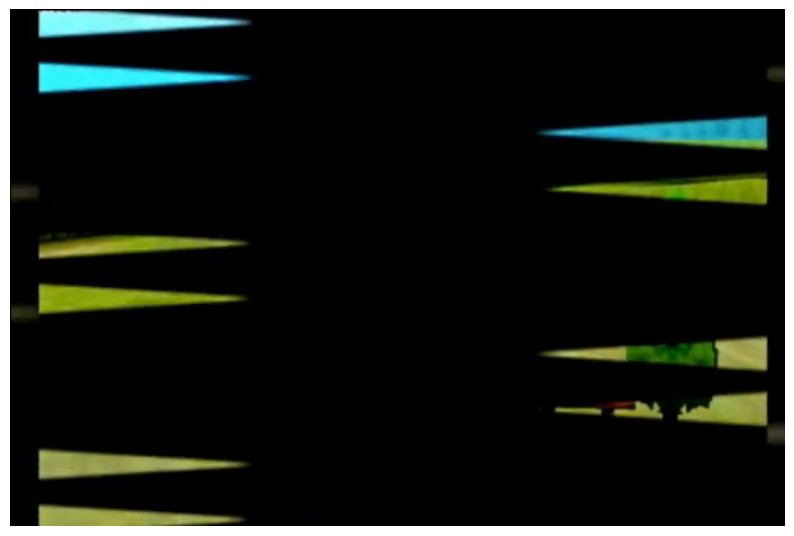

In [11]:
# Randomly select 1 image for plotting
import random
import matplotlib.pyplot as plt
import numpy as np
print(np.__file__)
print(np.__version__)
import sys

def plot_image_with_annotations(img, target):
    plt.figure(figsize=(10, 10))
    # Convert tensor to numpy and permute to HWC
    np_img = img.permute(1, 2, 0).cpu().numpy()
    print(f"Image shape before resize: {np_img.shape}")
    # np_img = cv2.resize(np_img, None, fx=2, fy=2)  # Resize to double the original size
    

    if len(target['boxes']) != 0:
        mask = np.sum(target['masks'].permute(1,2,0).cpu().numpy(), axis=2)
        mask = mask.astype(np.uint8)  # Ensure mask is in uint8 format
        print(f"Mask shape before resize: {mask.shape}")
        # mask = cv2.resize(mask, None, fx=2, fy=2, interpolation=cv2.INTER_NEAREST)  # Resize mask to match image size
        print(f"Mask shape: {mask.shape}, Image shape: {np_img.shape}")
        color_mask = np.zeros_like(np_img)
        # Create a color mask
        color_mask[mask > 0] = [0, 1.0, 0]

        # Blend the image and the mask
        alpha = 0.6  # Transparency factor
        overlay = cv2.addWeighted(np_img, 1 - alpha, color_mask, alpha, 0)
        plt.imshow(overlay)
    else:
        plt.imshow(np_img)
    
    # # If image has only 1 channel, squeeze and use cmap
    # if np_img.shape[2] == 1:
    #     np_img = np_img.squeeze(2)
    #     plt.imshow(np_img, cmap='gray')
    # else:
    #     plt.imshow(np_img)
    ax = plt.gca()
    # Draw boxes
    for box in target['boxes']:
        x1, y1, x2, y2 = (x for x in box.tolist())
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
    plt.axis('off')
    plt.show()

# Pick one random image to plot
idx = random.choice(range(len(data)))
img, target = data[idx]
print(f"Image {idx}: {img.shape}, Boxes: {target['boxes'].shape}, Labels: {target['labels']}, Masks: {target['masks'].shape}")
plot_image_with_annotations(img, target)

In [14]:
"""
For each image combine the masks into a single mask and save it as a .png file.
""" 
def combine_masks_by_class(img, target):
    labels = target['labels']
    masks = target['masks']  # shape: (num_masks, H, W)
    if masks.shape[0] == 1:
        return masks.numpy().squeeze(0)  # If only one mask, return it directly
    
    combined = torch.zeros(img.shape[1:], dtype=torch.uint8)
    for class_id in labels.unique():
        class_mask = masks[labels == class_id]
        if class_mask.shape[0] > 0:
            union = class_mask.any(dim=0).bool()
            combined[union] = class_id
    return combined.numpy()

def save_combined_mask(data, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for idx in range(len(data)):
        img, target = data[idx]
        combined =  combine_masks_by_class(img, target)
        # combined = cv2.resize(combined, (img.shape[2] * 2, img.shape[1] * 2), interpolation=cv2.INTER_NEAREST)
        print(f"Combined mask shape for image {idx}: {combined.shape}")
        mask_path = os.path.join(output_dir, f"mask_{idx:06d}.png")
        cv2.imwrite(mask_path, combined)  
        print(f"Saved combined mask for image {idx} to {mask_path}")

save_combined_mask(data, '/home/tmelanson/stadium_dataset/combined_masks')

Image shape: torch.Size([3, 480, 720]), Image path: /home/tmelanson/stadium_dataset/images/battle3/frame_000001.png
Combined mask shape for image 0: (480, 720)
Saved combined mask for image 0 to /home/tmelanson/stadium_dataset/combined_masks/mask_000000.png
Image shape: torch.Size([3, 480, 720]), Image path: /home/tmelanson/stadium_dataset/images/battle3/frame_000002.png
Combined mask shape for image 1: (480, 720)
Saved combined mask for image 1 to /home/tmelanson/stadium_dataset/combined_masks/mask_000001.png
Image shape: torch.Size([3, 480, 720]), Image path: /home/tmelanson/stadium_dataset/images/battle3/frame_000003.png
Combined mask shape for image 2: (480, 720)
Saved combined mask for image 2 to /home/tmelanson/stadium_dataset/combined_masks/mask_000002.png
Image shape: torch.Size([3, 480, 720]), Image path: /home/tmelanson/stadium_dataset/images/battle3/frame_000004.png
Combined mask shape for image 3: (480, 720)
Saved combined mask for image 3 to /home/tmelanson/stadium_dataset

In [15]:
from torch.utils.data import DataLoader

# Example DataLoader with memory optimization
image_dir = '/home/tmelanson/stadium_dataset/images'  # Adjust this path as needed
mask_dir = '/home/tmelanson/stadium_dataset/masks'  # Adjust this path as needed
transforms =  None  # Define any transformations if needed

train_loader = DataLoader(YOLOv8SegmentationDataset(image_dir, mask_dir, transforms=transforms), 
                          batch_size=8, shuffle=True, pin_memory=True)

In [ ]:
import torchvision.models.segmentation as models

model = models.deeplabv3_resnet50(pretrained=True)
num_classes = 3  # Adjust this based on your dataset
# Adjust the classifier head for your number of classes, e.g., binary or multi-class segmentation
model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

In [ ]:
import torch
import torch.nn as nn

class DiceLoss(nn.Module):
    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
    
    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        tp = (inputs * targets).sum()
        fp = ((1 - targets) * inputs).sum()
        fn = (targets * (1 - inputs)).sum()
        tversky = (tp + smooth) / (tp + self.alpha * fp + self.beta * fn + smooth)
        return 1 - tversky

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, steps_per_epoch=len(train_loader), epochs=20)

In [ ]:
scaler = torch.cuda.amp.GradScaler()
num_epochs = 20  # Adjust as needed

for epoch in range(num_epochs):
    model.train()
    for images, masks in train_loader:
        print(f"Epoch {epoch+1}/{num_epochs}, Batch size: {len(images)}")
        images, masks = images.cuda(), masks.cuda()
        
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = DiceLoss()(outputs, masks)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
    scheduler.step()

In [19]:
MASK_DIR= '/home/tmelanson/stadium_dataset/combined_masks/'
import cv2
i=0
for MASK_FILE in sorted(glob.glob(os.path.join(MASK_DIR, '*.png'))):
    i+=1
    if i < 100:
        continue
    if i > 200:  # Limit to first 10 masks for display
        break
    print(f"Processing mask file: {MASK_FILE}")
    mask = cv2.imread(MASK_FILE, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Failed to read mask from {MASK_FILE}")
    print(f"Mask shape: {mask.shape}, dtype: {mask.dtype}")
    cv2.imshow('Mask', mask*100)
    cv2.waitKey(0)
cv2.destroyAllWindows()

Processing mask file: /home/tmelanson/stadium_dataset/combined_masks/mask_000099.png
Mask shape: (480, 720), dtype: uint8
Processing mask file: /home/tmelanson/stadium_dataset/combined_masks/mask_000100.png
Mask shape: (480, 720), dtype: uint8
Processing mask file: /home/tmelanson/stadium_dataset/combined_masks/mask_000101.png
Mask shape: (480, 720), dtype: uint8
Processing mask file: /home/tmelanson/stadium_dataset/combined_masks/mask_000102.png
Mask shape: (480, 720), dtype: uint8
Processing mask file: /home/tmelanson/stadium_dataset/combined_masks/mask_000103.png
Mask shape: (480, 720), dtype: uint8
Processing mask file: /home/tmelanson/stadium_dataset/combined_masks/mask_000104.png
Mask shape: (480, 720), dtype: uint8
Processing mask file: /home/tmelanson/stadium_dataset/combined_masks/mask_000105.png
Mask shape: (480, 720), dtype: uint8
Processing mask file: /home/tmelanson/stadium_dataset/combined_masks/mask_000106.png
Mask shape: (480, 720), dtype: uint8
Processing mask file: /h